<a href="https://colab.research.google.com/github/ROPDIS/Models/blob/main/RESNET_Linearwarmupwithcosineannealing_Section5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Load the dependencies


In [ ]:
import numpy as np
import torch
import cv2 as cv2
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import os
from pathlib import Path
import glob
!pip install tensorflow==2.13
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling 

Step 2: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")




Mounted at /content/gdrive


Step 3: Import Images

In [ ]:
train_path = Path("/content/gdrive/MyDrive/Dis/Training Set Thumbnails")
test_path= Path("/content/gdrive/MyDrive/Dis/TestSetThumbnails")

test = Path('/content/gdrive/MyDrive/')







Training Data

In [ ]:
train_paths = list(train_path.glob(r"**/*.jpg"))




Testing Set

In [ ]:
test_paths = list(test_path.glob(r"**/*.jpg"))



Image Pre-processing


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(60,80),
                                        batch_size=32,
                                        class_mode='binary')


Found 17970 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(test_path, batch_size = 32,target_size=(60,80),class_mode='binary')

Found 1742 images belonging to 2 classes.


Calculating F-score

In [ ]:
def f_score(y_true, y_pred):
    true_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true, 0, 1)))
    predicted_positives = K.backend.sum(K.backend.round(K.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.backend.epsilon())
    recall = true_positives / (possible_positives + K.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.backend.epsilon())
    return f1_val

In [ ]:
# Custom Metric Functions
precision = Precision(name='precision')
recall = Recall(name='recall')
auc = AUC(name='auc')


CNN Model


In [ ]:
from tensorflow.keras.regularizers import L1

resnet = tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(60,80,3),
                   pooling=None,classes=2)

for layer in pretrained_model.layers:
  layer.trainable=False

resnet.add(pretrained_model)

resnet.add(tf.keras.layers.GlobalMaxPooling2D())  # Use GlobalMaxPooling2D
resnet.add(BatchNormalization())  # Add BatchNormalization layer
resnet.add(tf.keras.layers.Dropout(0.2,activity_regularizer=L1(0.01))) #Add Dropout Layer
resnet.add(tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=L1(0.01)))
resnet.add(BatchNormalization())  # Add BatchNormalization layer
resnet.add(tf.keras.layers.Dropout(0.2,activity_regularizer=L1(0.01))) #Add Dropout Layer
resnet.add(tf.keras.layers.Dense(1, activation='sigmoid'))

resnet.summary()




94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 3, 2048)        23564800  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                         

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping



decay_steps = 15000
initial_learning_rate = 0.0000002
warmup_steps = 3000
target_learning_rate = 0.02
lr_warmup_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps,alpha=0.00000002, warmup_target=target_learning_rate,warmup_steps=3000 )

# Configure the LearningRateScheduler callback
learning_rate_scheduler = LearningRateScheduler(lr_warmup_decayed_fn)


resnet.compile(optimizer=Adam(learning_rate=lr_warmup_decayed_fn), loss='binary_crossentropy', metrics=[precision, recall, auc, 'accuracy',f_score])

In [ ]:
history=resnet.fit(
    training_set,
    validation_data=test_set,
    epochs=45,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=25,
            restore_best_weights=True
        ),learning_rate_scheduler])

# Print the learning rate history
print(history.history["lr"])




Epoch 1/45
562/562 [==============================] - 2743s 5s/step - loss: 45.6059 - precision: 0.7163 - recall: 0.7500 - auc: 0.7548 - accuracy: 0.7043 - f_score: 0.7288 - val_loss: 6.2593 - val_precision: 0.9605 - val_recall: 0.5816 - val_auc: 0.7137 - val_accuracy: 0.5970 - val_f_score: 0.7169 - lr: 0.0037
Epoch 2/45
562/562 [==============================] - 70s 125ms/step - loss: 6.7206 - precision: 0.7131 - recall: 0.7903 - auc: 0.7846 - accuracy: 0.7149 - f_score: 0.7464 - val_loss: 8.5551 - val_precision: 0.9279 - val_recall: 0.8759 - val_auc: 0.7444 - val_accuracy: 0.8249 - val_f_score: 0.8993 - lr: 0.0075
Epoch 3/45
562/562 [==============================] - 70s 124ms/step - loss: 11.0531 - precision: 0.6959 - recall: 0.7794 - auc: 0.7667 - accuracy: 0.6967 - f_score: 0.7311 - val_loss: 13.4348 - val_precision: 0.9485 - val_recall: 0.8003 - val_auc: 0.7625 - val_accuracy: 0.7784 - val_f_score: 0.8651 - lr: 0.0112
Epoch 4/45
562/562 [==============================] - 70s 125m

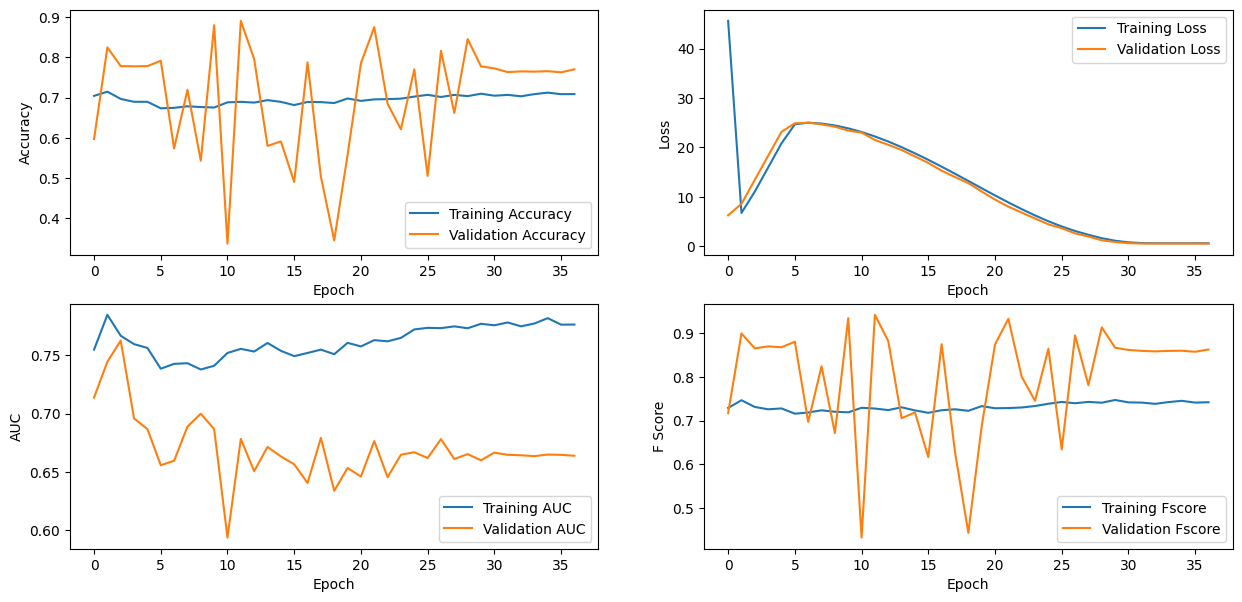

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.subplot(2, 2, 4)
plt.plot(history.history['f_score'], label='Training Fscore')
plt.plot(history.history['val_f_score'], label='Validation Fscore')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F Score')

plt.show()

55/55 [==============================] - 5s 79ms/step


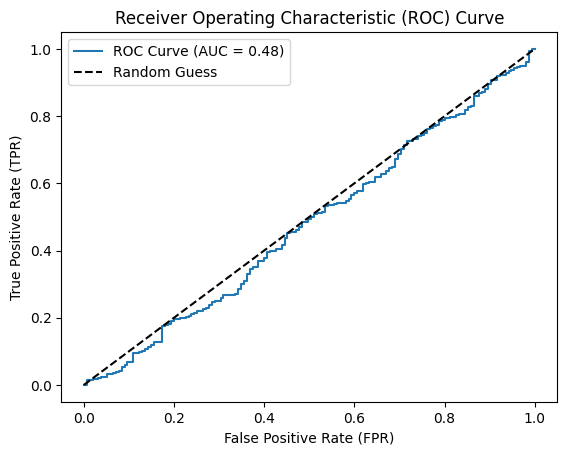

AUC: 0.47771205561314717


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score


# Make predictions on the test data
y_pred_prob = resnet.predict(test_set)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred = np.round(y_pred_prob).flatten()

# Get true target labels
y_true = test_set.classes

# Calculate the AUC
auc = roc_auc_score(y_true, y_pred_prob)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC
print("AUC:", auc)

